In [1]:
#### Necessary libraries ####
import numpy as np              # Numpy is the fundamental package for scientific computing in Python.
import netCDF4 as nc            # NetCDF is the data format of the meteorological data that we use.
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt # Matplotlib is a scientific plotting package.
import datetime                 # Datetime is a package to deal with dates.
import cartopy.crs as crs
import cartopy
from cmocean import cm
import os

import regionmask
import pandas as pd
import seaborn as sns

from shapely.geometry import Polygon, MultiPolygon  # In order to consider the rest of the world as source region
from shapely.ops import unary_union
# from mpl_toolkits.axes_grid1.inset_locator import InsetPosition # To insert map with CMIP regions
from matplotlib.ticker import FormatStrFormatter

from Functions import * 
from combine_data import *

#Data and output paths
basedir = "./data/"
figure_path= "./Figures/"


# The statement below enforces the plots to be put into this notebook, instead of in their own windows.
%matplotlib inline

# Definition of two functions to select regions and plot

In [2]:
def define_cmip_regions(basedir, casename):
    '''Define regions, also provides an example how to define them using the regionmask package. 

    Now 'rest of the world', as well as the 'event' or 'sink' region, are also defined using the
    same package.
    '''

    # Define different regions depending on the case
    if casename=="Pakistan":
        regions_list = ["NEAF", "SEAF", "TIB", "WCA", "ARP", "SAS", "ARS", "BOB", "EIO", "SIO"]
        boxfile = basedir+casename+f"/Mask_PakistanFlood_box_lon-180to180.nc"
        sink_da = xr.open_dataset(boxfile)['mask']
    else:
        if casename=="Scotland":
            regions_list = ["ENA", "CAR", "NEU", "WCE", "MED", "NAO"]
            boxfile = basedir+casename+f"/mask_scotland_box_lon-180to180.nc"
        elif casename=="Australia":
            regions_list = ["NAU", "CAU", "EAU", "SAU", "NZ", "EPO", "SPO", "SOO"]
            boxfile = basedir+casename+f"/mask_australia_box_lon-180to180.nc"
        sink_da = xr.open_dataset(boxfile)['mask'].isel(time=0)

    ar6_all = regionmask.defined_regions.ar6.all
    selected_regions = ar6_all[regions_list]

    # Create region representing the rest of the world
    ipcc_union = unary_union(selected_regions.polygons)
    global_box_coords = [(-180, -90), (180, -90), (180, 90), (-180, 90)]
    global_polygon = Polygon(global_box_coords)
    complementary_polygon = global_polygon.difference(ipcc_union)
    comp_region = regionmask.Regions([complementary_polygon], names=['Other'], abbrevs=['Other'])

    # Merge the IPCC regions and the rest of the world in selected_regions
    selected_regions = regionmask.Regions([*selected_regions.polygons, *comp_region.polygons],\
        names=[*selected_regions.names, *comp_region.names],\
        abbrevs=[*selected_regions.abbrevs, *comp_region.abbrevs],\
        numbers=[*selected_regions.numbers, *(np.array(comp_region.numbers) + max(selected_regions.numbers) + 1)])

    # Create also another region representing the sink box and add it
    sink_lats = sink_da.lat[np.where(sink_da.values>0)[0]]
    sink_lons = sink_da.lon[np.where(sink_da.values>0)[1]]        
    latmin = sink_lats.min(); latmax = sink_lats.max()
    lonmin = sink_lons.min(); lonmax = sink_lons.max()
    sink_polygon = Polygon([(lonmin, latmin), (lonmax, latmin), (lonmax, latmax), (lonmin, latmax)])
    sink_region = regionmask.Regions([sink_polygon], names=['sink'], abbrevs=['sink'])
    all_regions = regionmask.Regions([*selected_regions.polygons, *comp_region.polygons, *sink_region.polygons],\
        names=[*selected_regions.names, *comp_region.names, *sink_region.names],\
        abbrevs=[*selected_regions.abbrevs, *comp_region.abbrevs, *sink_region.abbrevs],\
        numbers=[*selected_regions.numbers, *(np.array(comp_region.numbers) + max(selected_regions.numbers) + 1),\
                                            *(np.array(sink_region.numbers) + max(selected_regions.numbers) + 1)])
    sink_da.close()

    return selected_regions, all_regions

In [18]:
def beeswarm_plot(ax, df, fontsize=14, yscale='linear', **kwargs):
    ''' 
    We use a beeswarm plot, which prevents points from overlapping. However, the beeswarm function in the seaborn library does not allow
    to use different markers to distinguish the default from the ensemble members, so we get the positions and use a scatter plot.
    Then we add a boxplot to highlight the multimethod mean. Observe that only the default ensemble members are used in the boxplot.
    '''

    # Assign a color for each model
    colors = {'WAM2layers': 'yellow', '2LDRM': 'orange', 'UTrack': 'red', 'B-TrIMS': 'firebrick', 'TRACMASS': 'teal', 'FLEXPART-HAMSTER': 'cyan',\
            'FLEXPART-WaterSip (UiB)': 'lightblue', 'FLEXPART-WaterSip (UniVie)': 'deepskyblue', 'LAGRANTO-WaterSip (CHc)': 'cornflowerblue',\
            'FLEXPART-WaterSip (IBCAS)': 'blue', 'FLEXPART-WaterSip (HKUST)': 'navy', 'FLEXPART-LATTIN (UVigo)': 'mediumslateblue',\
            'FLEXPART-Stohl (UVigo)': 'purple', 'WRF-WVT': 'limegreen'}
    
    # Create swarmplot and hide it (with this function we cannot use different markers)
    # Proceed differently depending on the chosen scale
    if yscale=='two-slope':
        if len(kwargs)==0:
            x0 = 20.; y0 = 40.
        else:
            x0 = kwargs['x0']
            y0 = kwargs['y0']
            
        yvalues = df['value'].values
        df['value'] = [np.sqrt(x/x0)*y0 if x<=x0 else y0+(100.-y0)/(100.-x0)*(x-x0) for x in yvalues]

        # Create the swarmplot to get yticks and labels
        sw = sns.swarmplot(ax = ax, data=df, x=df['region'], y=df['value'], hue=df['name'], palette=colors, size=8)
        ticks = sw.get_yticks()
        labels = [(y/y0)**2*x0 if y<=y0 else x0+(y-y0)*(100.-x0)/(100.-y0) for y in ticks]
    else:
        sw = sns.swarmplot(ax = ax, data=df, x=df['region'], y=df['value'], hue=df['name'], palette=colors, size=8)
        ticks = sw.get_yticks()
        labels = ticks.copy()

    # Get the positions and create a new data frame with the information we need for plotting
    x = []; y = []
    for coll in sw.collections:
        data = coll.get_offsets()
        x.append(data[:,0]), y.append(data[:,1])

    x = np.array(x); y = np.array(y)
    #sw.collections.clear()
    #sw.clear()
    
    regions = df['region'].unique(); nregions = len(regions)
    models = df['model'].unique(); nmodels = len(models)
    order_df = df[['region', 'model']].values.tolist()
    order_xy = np.array([np.repeat(regions, nmodels), np.tile(models, nregions)]).transpose().tolist()
    order = [order_xy.index(item) for item in order_df]
    df['x'] = x.flatten()[order]; df['y'] = y.flatten()[order]
    df['color'] = [colors[name] for name in df['name']]

    # Now plot
    df1 = df[df['ens']==0.]
    ax.scatter(df1['x'], df1['y'], s=80, c=df1['color'].values.tolist())
    df2 = df[df['ens']==1.]
    ax.scatter(df2['x'], df2['y'], s=50, c=df2['color'].values.tolist(), marker='$\circ$', linewidths=0.5) #'$\circ$') "x"

    # Add boxplot
    sns.boxplot(ax=ax, data=df1, x=df1['region'], y=df1['value'], color='lightgrey', fliersize=0, zorder=0)

    # Labels and ticks
    ax.set_xticks(np.arange(nregions))
    regions_labels = [region.replace('-', ' \n ') for region in regions]
    ax.set_xticklabels(regions_labels, rotation=0, size=fontsize)
    ax.set_xlabel('')
    ax.set_ylabel('Fraction (%)', size=fontsize)
    ax.set_yticks(ticks=ticks, labels=labels)
    ax.set_yticklabels(FormatStrFormatter('%.2f').format_ticks(labels))
    ax.tick_params('y', labelsize=fontsize)

    # Horizontal grid lines
    ax.grid(axis="y")

    # Set y limit
    ax.set_ylim([df['value'].min()-2., df['value'].max()+2.])

    return ax, sw

# CMIP Regions

In [19]:
'''
Get the selected CMIP regions depending on the case
'''


selected_regions_pakistan, all_regions_pakistan = define_cmip_regions(basedir, "Pakistan")
print(selected_regions_pakistan.names)

selected_regions_australia, all_regions_australia = define_cmip_regions(basedir, "Australia")
print(selected_regions_australia.names)

selected_regions_scotland, all_regions_scotland = define_cmip_regions(basedir, "Scotland")
print(selected_regions_scotland.names)

['N.Eastern-Africa', 'S.Eastern-Africa', 'W.C.Asia', 'Tibetan-Plateau', 'Arabian-Peninsula', 'S.Asia', 'Arabian-Sea', 'Bay-of-Bengal', 'Equatorial.Indic-Ocean', 'S.Indic-Ocean', 'Other']
['N.Australia', 'C.Australia', 'E.Australia', 'S.Australia', 'New-Zealand', 'Equatorial.Pacific-Ocean', 'S.Pacific-Ocean', 'Southern-Ocean', 'Other']
['E.North-America', 'Caribbean', 'N.Europe', 'West&Central-Europe', 'Mediterranean', 'N.Atlantic-Ocean', 'Other']



# Data loading and calculation of regional sources

In [20]:
# Pakistan
# Load data and calculate (area weighted) fractional sources
casename = "Pakistan"
all_regions = all_regions_pakistan
srcs = read_data(basedir, casename)
srcs_frac = calc_fractional_sources(srcs)

# Compute regional sources
# For WRF-WVT, we need to compute it separately, as it corresponds to another tagging experiment
srcs_regional, weights = calc_regional_sources(srcs_frac, all_regions)
ds = xr.open_dataset(basedir+casename+"/results WRF-WVT/"+casename+"_Rain-TracerRain.nc")
frac = np.sum(ds.tr_rain.values*ds.trmask.values)/np.sum(ds.rain.values*ds.trmask.values)*100
srcs_regional['WRF-WVT'] = xr.where(srcs_regional['names']=='sink', frac, srcs_regional['WRF-WVT'])

# Create a data frame with the results for plotting
models = [var for var in srcs_regional.data_vars]
names = [model[:model.find('Ens')].rstrip(' ') if 'Ens' in model else model for model in models]
regions = srcs_regional.region.names.values
values = srcs_regional[models].to_array().values.flatten()
nmodels = len(models); nregions = len(regions)
df = pd.DataFrame({'value': values, 'region': np.tile(regions, nmodels),\
                   'model': np.repeat(models, nregions), 'name': np.repeat(names, nregions)})

#Main and additional members
def_members = ['UTrack Ens2', 'FLEXPART-HAMSTER Ens5', 'FLEXPART-WaterSip (HKUST) Ens2']
add_members = [model for model in models if 'Ens' in model and model not in def_members]

# Add a column for identifying additional ensemble members
df['ens'] = [1 if model in add_members  else 0 for model in df['model']]

# Save data frame
df_pakistan = df.copy()

Loading wam2layers data for Pakistan
Loading 2ldrm data for Pakistan
Loading utrack data for Pakistan
Loading btrims data for Pakistan
Loading tracmass data for Pakistan
Loading ughent data for Pakistan
Loading UIB data for Pakistan
Loading UniVie data for Pakistan
Loading CHc data for Pakistan
Loading xu data for Pakistan
Loading tatfancheng data for Pakistan
Loading uvigo data for Pakistan
Loading WRF-WVT data for Pakistan


/home/peter/miniforge3/envs/effortsharing_env/lib/python3.11/site-packages/regionmask/core/mask.py:406: UserWarning: Detected overlapping regions. As of v0.11.0 these are correctly taken into account. Note, however, that a different mask is returned than with older versions of regionmask. To suppress this warning, set `overlap=True` (to restore the old, incorrect, behaviour, set `overlap=False`).
  warnings.warn(


In [21]:
# Repeat for Australia
# Load data
casename = "Australia"
all_regions = all_regions_australia
srcs = read_data(basedir, casename)
srcs_frac = calc_fractional_sources(srcs)

# Regional sources
srcs_regional, weights = calc_regional_sources(srcs_frac, all_regions)
ds = xr.open_dataset(basedir+casename+"/results WRF-WVT/"+casename+"_Rain-TracerRain.nc")
frac = np.sum(ds.tr_rain.values*ds.trmask.values)/np.sum(ds.rain.values*ds.trmask.values)*100
srcs_regional['WRF-WVT'] = xr.where(srcs_regional['names']=='sink', frac, srcs_regional['WRF-WVT'])

# Data frame
models = [var for var in srcs_regional.data_vars]
names = [model[:model.find('Ens')].rstrip(' ') if 'Ens' in model else model for model in models]
regions = srcs_regional.region.names.values
values = srcs_regional[models].to_array().values.flatten()
nmodels = len(models); nregions = len(regions)
df = pd.DataFrame({'value': values, 'region': np.tile(regions, nmodels),\
                   'model': np.repeat(models, nregions), 'name': np.repeat(names, nregions)})

# Add a column for identifying additional ensemble members
df['ens'] = [1 if model in add_members  else 0 for model in df['model']]
df_australia = df.copy()

Loading wam2layers data for Australia
Loading 2ldrm data for Australia
Loading utrack data for Australia
Loading btrims data for Australia
Loading tracmass data for Australia
Loading ughent data for Australia
Loading UIB data for Australia
Loading UniVie data for Australia
Loading CHc data for Australia
Loading xu data for Australia
Loading tatfancheng data for Australia
Loading uvigo data for Australia
Loading WRF-WVT data for Australia


/home/peter/miniforge3/envs/effortsharing_env/lib/python3.11/site-packages/regionmask/core/mask.py:406: UserWarning: Detected overlapping regions. As of v0.11.0 these are correctly taken into account. Note, however, that a different mask is returned than with older versions of regionmask. To suppress this warning, set `overlap=True` (to restore the old, incorrect, behaviour, set `overlap=False`).
  warnings.warn(


In [22]:
# Finally, for Scotland
# Load data
casename = "Scotland"
all_regions = all_regions_scotland
srcs = read_data(basedir, casename)
srcs_frac = calc_fractional_sources(srcs)

# Regional sources
srcs_regional, weights = calc_regional_sources(srcs_frac, all_regions)
ds = xr.open_dataset(basedir+casename+"/results WRF-WVT/"+casename+"_Rain-TracerRain.nc")
frac = np.sum(ds.tr_rain.values*ds.trmask.values)/np.sum(ds.rain.values*ds.trmask.values)*100
srcs_regional['WRF-WVT'] = xr.where(srcs_regional['names']=='sink', frac, srcs_regional['WRF-WVT'])

# Data frame
models = [var for var in srcs_regional.data_vars]
names = [model[:model.find('Ens')].rstrip(' ') if 'Ens' in model else model for model in models]
regions = srcs_regional.region.names.values
values = srcs_regional[models].to_array().values.flatten()
nmodels = len(models); nregions = len(regions)
df = pd.DataFrame({'value': values, 'region': np.tile(regions, nmodels),\
                   'model': np.repeat(models, nregions), 'name': np.repeat(names, nregions)})

# Add a column for identifying additional ensemble members
df['ens'] = [1 if model in add_members  else 0 for model in df['model']]
df_scotland = df.copy()

Loading wam2layers data for Scotland
Loading 2ldrm data for Scotland
Loading utrack data for Scotland
Loading btrims data for Scotland
Loading tracmass data for Scotland
Loading ughent data for Scotland
Loading UIB data for Scotland
Loading UniVie data for Scotland
Loading CHc data for Scotland
Loading xu data for Scotland
Loading tatfancheng data for Scotland
Loading uvigo data for Scotland
Loading WRF-WVT data for Scotland


/home/peter/miniforge3/envs/effortsharing_env/lib/python3.11/site-packages/regionmask/core/mask.py:406: UserWarning: Detected overlapping regions. As of v0.11.0 these are correctly taken into account. Note, however, that a different mask is returned than with older versions of regionmask. To suppress this warning, set `overlap=True` (to restore the old, incorrect, behaviour, set `overlap=False`).
  warnings.warn(


## Figures

/home/peter/miniforge3/envs/effortsharing_env/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/peter/miniforge3/envs/effortsharing_env/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 20.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/peter/miniforge3/envs/effortsharing_env/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/peter/miniforge3/envs/effortsharing_env/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.

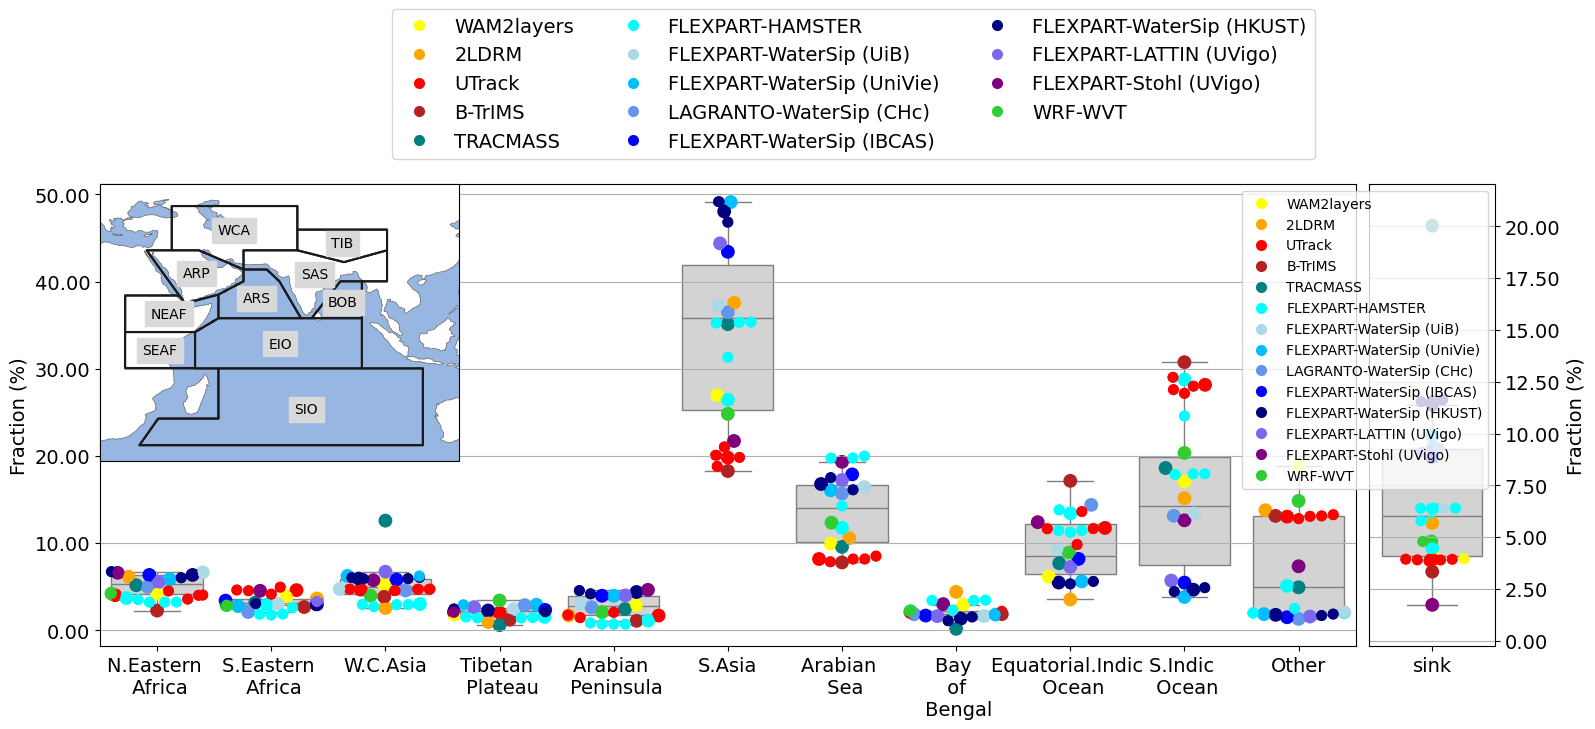

In [23]:
# Example of how to produce one single figure
# Pakistan
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), width_ratios=[10, 1])
plt.subplots_adjust(wspace=0.02)
fontsize = 14
my_proj = crs.PlateCarree(central_longitude=0.0)

# Beeswarm plot of CMIP regions
ax = axs[0]
df = df_pakistan.copy()
df_nosink = df.drop(df[df['region']=='sink'].index)
ax, sw =beeswarm_plot(ax, df_nosink, fontsize=fontsize)
ax.legend(bbox_to_anchor=(0.6, 1.4), loc='upper center', ncols=3, prop={'size': fontsize})

# Recycling
ax = axs[1]
df_sink = df.drop(df[df['region']!='sink'].index)
beeswarm_plot(ax, df_sink, fontsize=fontsize)
#ax.get_legend().remove()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

# IPCC regions
p1 = axs[0].get_position()
ax2 = fig.add_axes([p1.x0, p1.y1-1.2*p1.height/2, p1.width/3.5, 1.2*p1.height/2], projection=my_proj)
selected_regions_pakistan.plot(ax=ax2, label="abbrev", add_ocean=True)
ax2.set_extent([20., 120., -30., 40.])
ax2.set_aspect('auto')

/home/peter/miniforge3/envs/effortsharing_env/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/peter/miniforge3/envs/effortsharing_env/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/peter/miniforge3/envs/effortsharing_env/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/peter/miniforge3/envs/effortsharing_env/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 41.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings

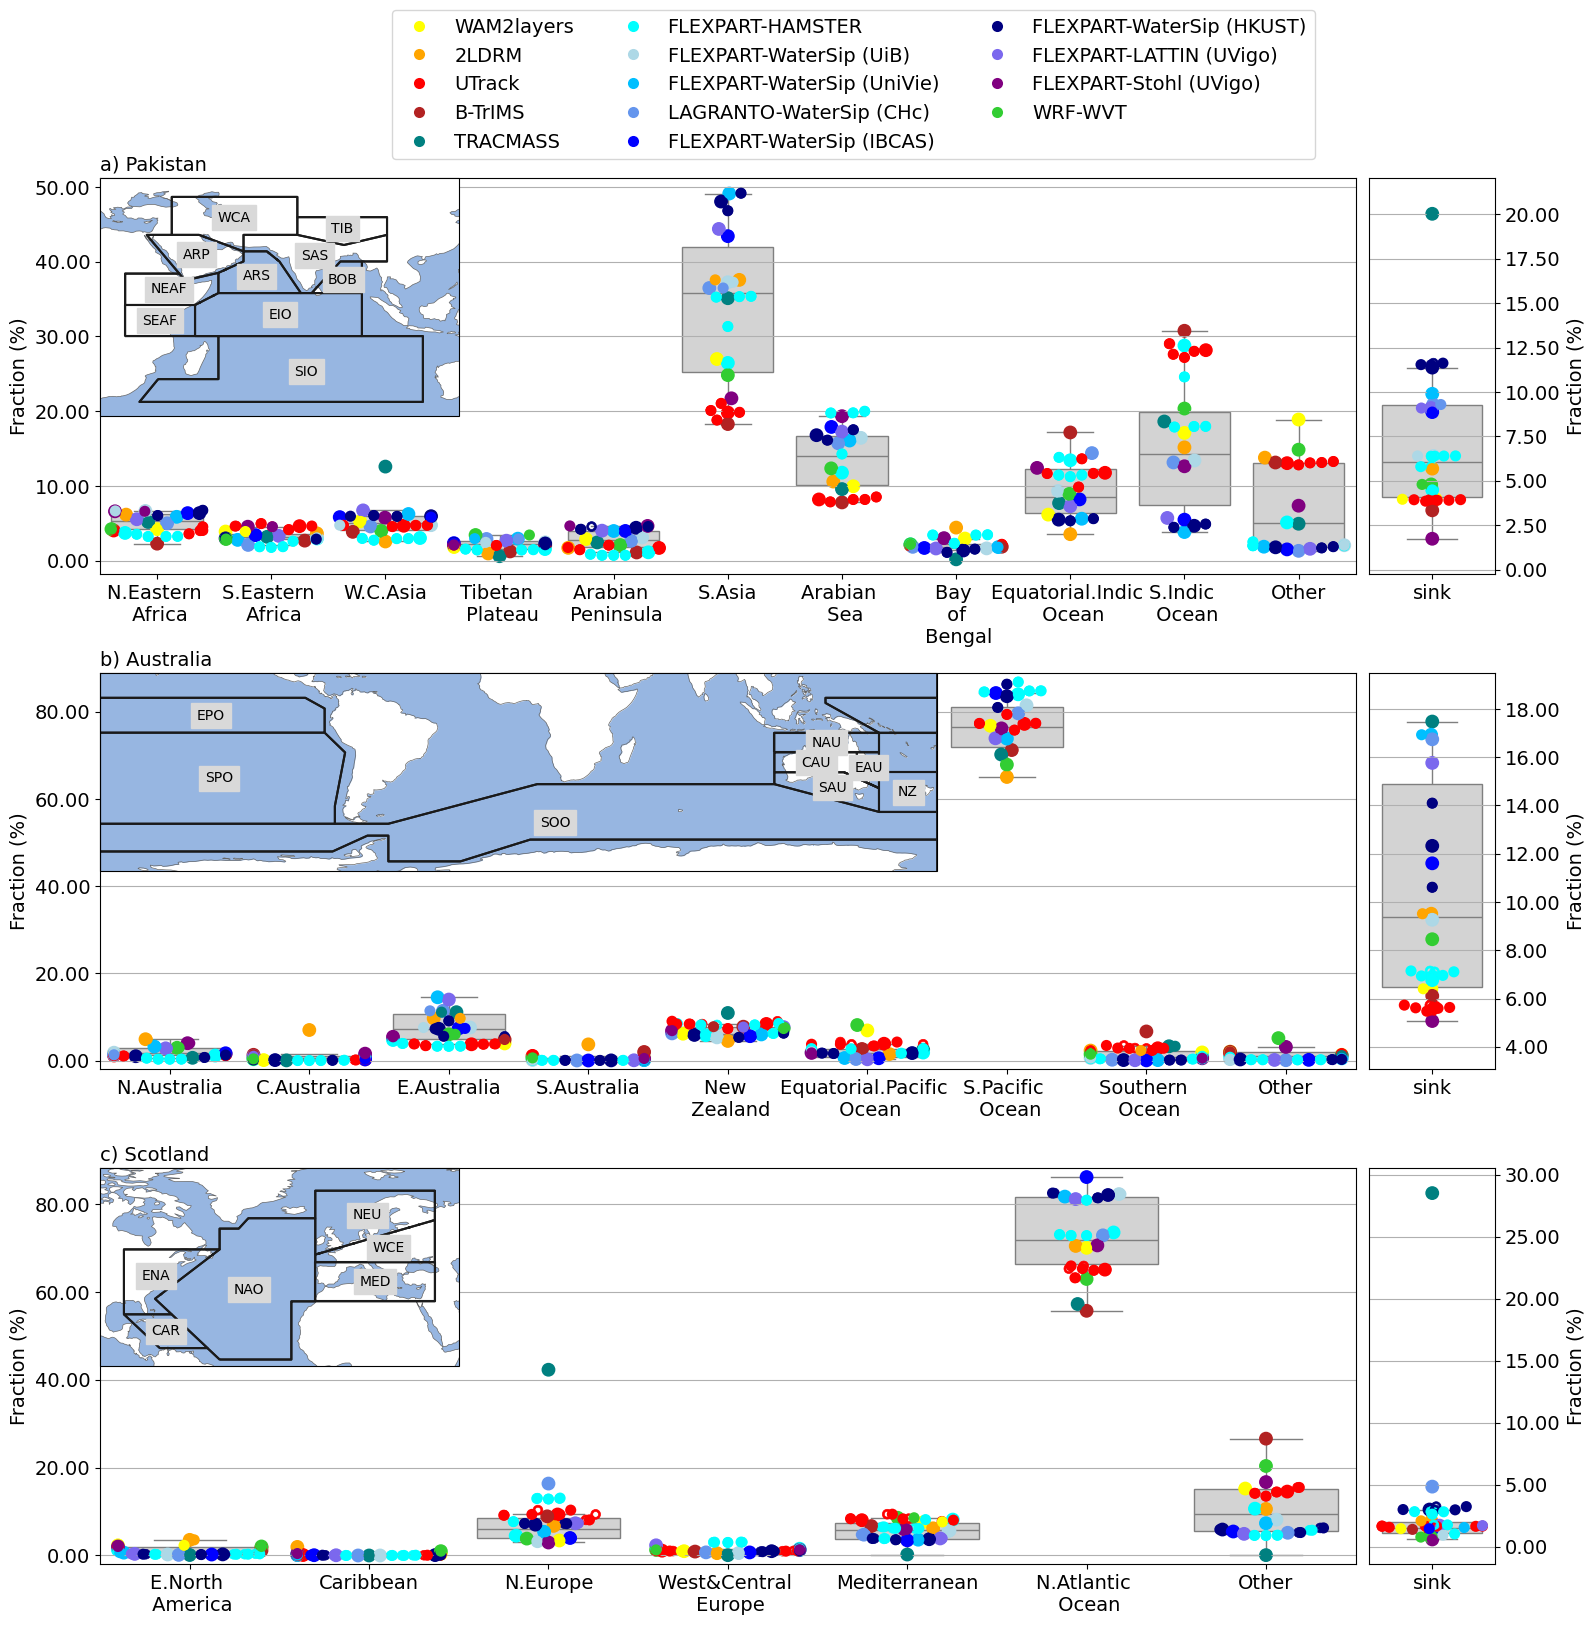

In [24]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 18), width_ratios=[10, 1])
plt.subplots_adjust(wspace=0.02, hspace=0.25)
fontsize = 14
my_proj = crs.PlateCarree(central_longitude=0.0)

# Pakistan
# Beeswarm plot of CMIP regions
ax = axs[0, 0]
df = df_pakistan.copy()
df_nosink = df.drop(df[df['region']=='sink'].index)
beeswarm_plot(ax, df_nosink, fontsize=fontsize)
ax.legend(bbox_to_anchor=(0.6, 1.45), loc='upper center', ncols=3, prop={'size': fontsize})
ax.set_title('a) Pakistan', fontsize=fontsize, loc='left')

# Recycling
ax = axs[0, 1]
df_sink = df.drop(df[df['region']!='sink'].index)
beeswarm_plot(ax, df_sink, fontsize=fontsize)
ax.get_legend().remove()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

# IPCC regions
p1 = axs[0, 0].get_position()
ax2 = fig.add_axes([p1.x0, p1.y1-1.2*p1.height/2, p1.width/3.5, 1.2*p1.height/2], projection=my_proj)
selected_regions_pakistan.plot(ax=ax2, label="abbrev", add_ocean=True)
ax2.set_extent([20., 120., -30., 40.])
ax2.set_aspect('auto')

# Australia
# Beeswarm plot of CMIP regions
ax = axs[1, 0]
df = df_australia.copy()
df_nosink = df.drop(df[df['region']=='sink'].index)
beeswarm_plot(ax, df_nosink, fontsize=fontsize)
ax.get_legend().remove()
ax.set_title('b) Australia', fontsize=fontsize, loc='left')

# Recycling
ax = axs[1, 1]
df_sink = df.drop(df[df['region']!='sink'].index)
beeswarm_plot(ax, df_sink, fontsize=fontsize)
ax.get_legend().remove()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

# IPCC regions
p1 = axs[1, 0].get_position()
ax2 = fig.add_axes([p1.x0, p1.y1-1.5*p1.height/3, p1.width/1.5, 1.5*p1.height/3], projection=my_proj)
selected_regions_australia.plot(ax=ax2, label="abbrev", add_ocean=True)
ax2.set_extent([-160., 180., -80., 20.])
ax2.set_aspect('auto')

# Scotland
# Beeswarm plot of CMIP regions
ax = axs[2, 0]
df = df_scotland.copy()
df_nosink = df.drop(df[df['region']=='sink'].index)
beeswarm_plot(ax, df_nosink, fontsize=fontsize)
ax.get_legend().remove()
ax.set_title('c) Scotland', fontsize=fontsize, loc='left')

# Recyling
ax = axs[2, 1]
df_sink = df.drop(df[df['region']!='sink'].index)
beeswarm_plot(ax, df_sink, fontsize=fontsize)
ax.get_legend().remove()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

# IPCC regions
p1 = axs[2, 0].get_position()
ax2 = fig.add_axes([p1.x0, p1.y1-1.5*p1.height/3, p1.width/3.5, 1.5*p1.height/3], projection=my_proj)
selected_regions_scotland.plot(ax=ax2, label="abbrev", add_ocean=True)
ax2.set_extent([-100., 50., 5., 60.])
ax2.set_aspect('auto')

plt.savefig(figure_path + 'Figure5_BeeswarmAndBoxPlots_AllCases.png', dpi=600, bbox_inches='tight')

/home/peter/miniforge3/envs/effortsharing_env/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/peter/miniforge3/envs/effortsharing_env/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/peter/miniforge3/envs/effortsharing_env/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/peter/miniforge3/envs/effortsharing_env/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.

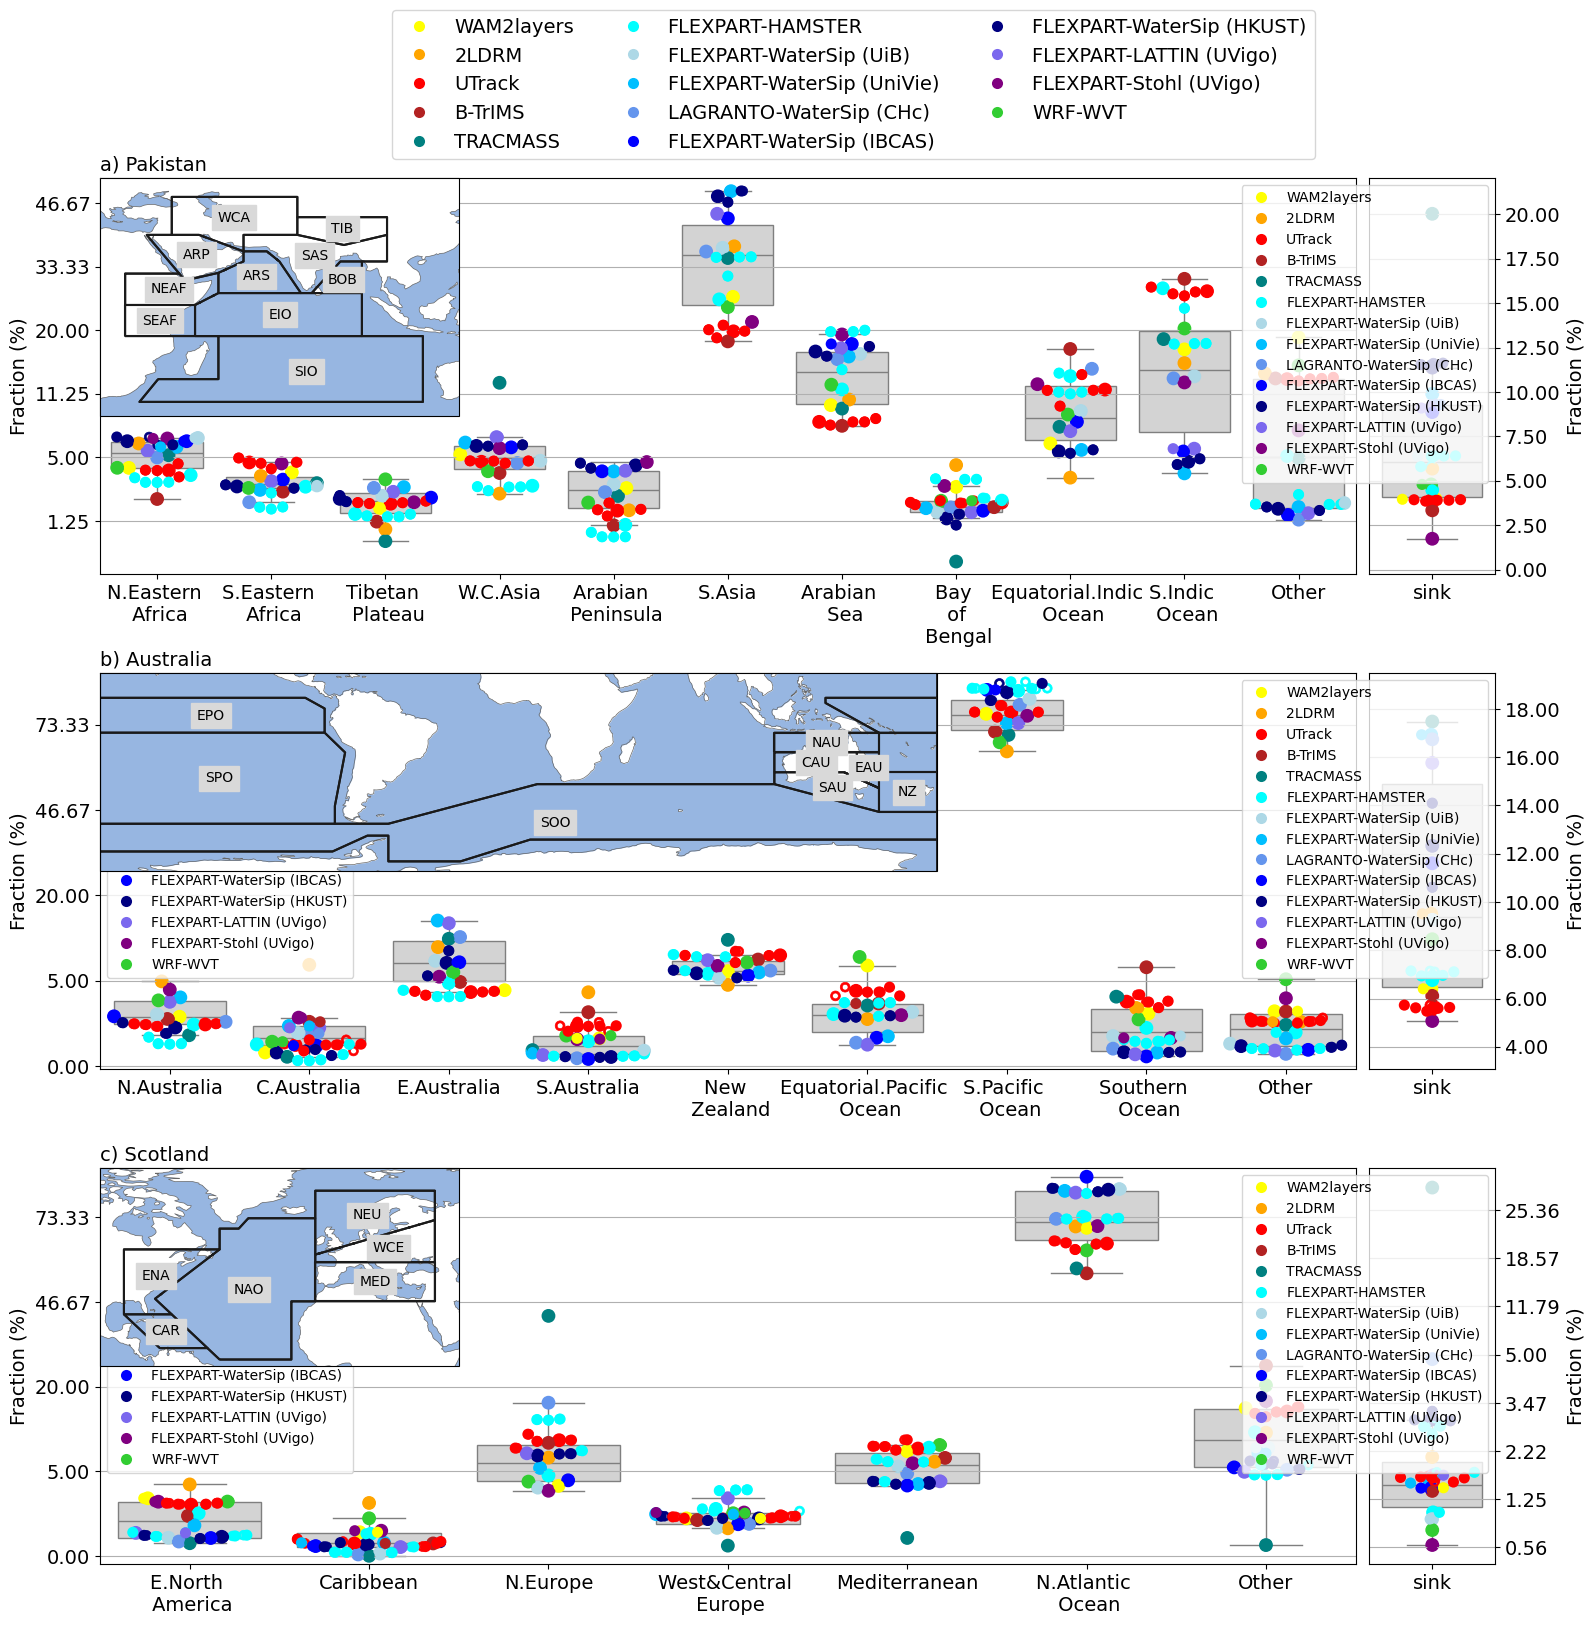

In [26]:
# Repeat for a two slope scale
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 18), width_ratios=[10, 1])
plt.subplots_adjust(wspace=0.02, hspace=0.25)
fontsize = 14
my_proj = crs.PlateCarree(central_longitude=0.0)

# Pakistan
# We need to exchange the position of two regions for no overlapping with the map of CMIP regions
df_pakistan_copy = df_pakistan.copy()
df_pakistan_copy.loc[df_pakistan['region']=='W.C.Asia', :] = df_pakistan.loc[df_pakistan['region']=='Tibetan-Plateau', :].values
df_pakistan_copy.loc[df_pakistan['region']=='Tibetan-Plateau', :] = df_pakistan.loc[df_pakistan['region']=='W.C.Asia', :].values

# Beeswarm plot of CMIP regions
ax = axs[0, 0]
df = df_pakistan_copy
df_nosink = df.drop(df[df['region']=='sink'].index)
beeswarm_plot(ax, df_nosink, fontsize=fontsize, yscale='two-slope')
ax.legend(bbox_to_anchor=(0.6, 1.45), loc='upper center', ncols=3, prop={'size': fontsize})
ax.set_title('a) Pakistan', fontsize=fontsize, loc='left')

# Recycling
ax = axs[0, 1]
df_sink = df.drop(df[df['region']!='sink'].index)
beeswarm_plot(ax, df_sink, fontsize=fontsize)
#ax.get_legend().remove()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

# IPCC regions
p1 = axs[0, 0].get_position()
ax2 = fig.add_axes([p1.x0, p1.y1-1.2*p1.height/2, p1.width/3.5, 1.2*p1.height/2], projection=my_proj)
selected_regions_pakistan.plot(ax=ax2, label="abbrev", add_ocean=True)
ax2.set_extent([20., 120., -30., 40.])
ax2.set_aspect('auto')

# Australia
# Beeswarm plot of CMIP regions
ax = axs[1, 0]
df = df_australia.copy()
df_nosink = df.drop(df[df['region']=='sink'].index)
beeswarm_plot(ax, df_nosink, fontsize=fontsize, yscale='two-slope')
#ax.get_legend().remove()
ax.set_title('b) Australia', fontsize=fontsize, loc='left')

# Recycling
ax = axs[1, 1]
df_sink = df.drop(df[df['region']!='sink'].index)
beeswarm_plot(ax, df_sink, fontsize=fontsize)
#ax.get_legend().remove()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

# IPCC regions
p1 = axs[1, 0].get_position()
ax2 = fig.add_axes([p1.x0, p1.y1-1.5*p1.height/3, p1.width/1.5, 1.5*p1.height/3], projection=my_proj)
selected_regions_australia.plot(ax=ax2, label="abbrev", add_ocean=True)
ax2.set_extent([-160., 180., -80., 20.])
ax2.set_aspect('auto')

# Scotland
# Beeswarm plot of CMIP regions
ax = axs[2, 0]
df = df_scotland.copy()
df_nosink = df.drop(df[df['region']=='sink'].index)
beeswarm_plot(ax, df_nosink, fontsize=fontsize, yscale='two-slope')
#ax.get_legend().remove()
ax.set_title('c) Scotland', fontsize=fontsize, loc='left')

# Recyling
ax = axs[2, 1]
df_sink = df.drop(df[df['region']!='sink'].index)
beeswarm_plot(ax, df_sink, fontsize=fontsize, yscale='two-slope', x0=5., y0=30.)
#ax.get_legend().remove()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

# IPCC regions
p1 = axs[2, 0].get_position()
ax2 = fig.add_axes([p1.x0, p1.y1-1.5*p1.height/3, p1.width/3.5, 1.5*p1.height/3], projection=my_proj)
selected_regions_scotland.plot(ax=ax2, label="abbrev", add_ocean=True)
ax2.set_extent([-100., 50., 5., 60.])
ax2.set_aspect('auto')

plt.savefig(figure_path + 'BeeswarmAndBoxPlots_AllCases_TwoSlopeScale.png', dpi=600, bbox_inches='tight')